In [1]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from lupy.meter import Meter
from lupy.processing import lk_log10, from_lk_log10
from lupy.types import *

from conftest import cases_by_name, ComplianceBase

Fs = 48000
BLOCK_SIZE = 128

In [2]:
def process_all(meter: Meter, src_data: Float2dArray):
    num_channels, block_size = meter.num_channels, meter.block_size
    N = src_data.shape[1]

    remain = N % block_size
    if remain > 0:
        src_data = src_data[:,:N-remain]
    num_blocks = N // block_size
    src_data = np.reshape(src_data, (num_channels, num_blocks, block_size))

    write_index = 0
    while write_index < num_blocks:
        while meter.can_write() and write_index < num_blocks:
            meter.write(src_data[:,write_index,:])
            write_index += 1
    assert write_index >= num_blocks
    meter.process()
    assert not meter.can_process()


In [3]:
def get_zero_ix(test_case: ComplianceBase) -> int:
    N = 0
    for inp in test_case.input:
        n = int(round(Fs * inp.duration))
        assert n == Fs * inp.duration

        if np.all(np.isnan(inp.dBFS)):
            break
        N += n
    return N

meter = Meter(num_channels=5, block_size=BLOCK_SIZE)
test_case = cases_by_name['3342']['case1']
silence_start_ix = get_zero_ix(test_case)
silence_start_t = silence_start_ix / Fs


In [4]:
src_data = test_case.generate_samples(Fs)
assert np.all(np.equal(src_data[:,silence_start_ix:], 0))

generating samples


In [5]:
t = np.arange(src_data.shape[1]) / Fs
_src_data_nonzero = src_data[0].view(np.ma.MaskedArray)
_src_data_nonzero[silence_start_ix:] = np.ma.masked
_src_data_zero = src_data[0].view(np.ma.MaskedArray)
_src_data_zero[:silence_start_ix] = np.ma.masked

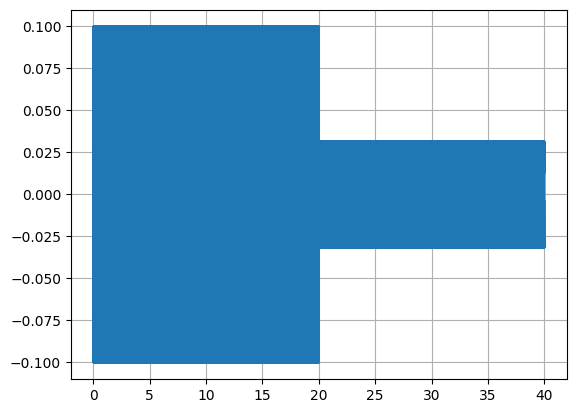

In [6]:
plt.plot(t, _src_data_nonzero, t, _src_data_zero)
plt.grid()

In [7]:
process_all(meter, src_data)
print(f'{meter.processor.integrated_lkfs=}')

meter.processor.integrated_lkfs=-22.59635996275023


st_min=-29.99998590453396, st_min_ix=283, st_min_t=28.3


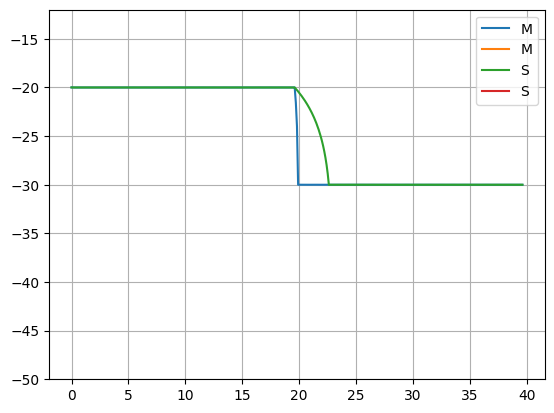

In [8]:
block_data = meter.block_data
block_data_nonzero = block_data.view(np.ma.MaskedArray)
block_t = block_data['t']
nonzero_ix = np.less(block_t, silence_start_t)
zero_ix = np.greater_equal(block_t, silence_start_t)
block_data_nonzero[zero_ix] = np.ma.masked
block_data_zero = block_data.view(np.ma.MaskedArray)
block_data_zero[nonzero_ix] = np.ma.masked
plt.plot(block_t, block_data_nonzero['m'], block_t, block_data_zero['m'], label='M')
plt.plot(block_t, block_data_nonzero['s'], block_t, block_data_zero['s'], label='S')
# plt.plot(meter.t, meter.momentary_lkfs, label='M')
# plt.plot(meter.t, meter.short_term_lkfs, label='S')

st_neg_30_ix = np.flatnonzero(block_data['s']<=-30)
if st_neg_30_ix.size:
    st_neg_30 = st_neg_30_ix.min()
    st_neg_30_t = block_t[st_neg_30]
    print(f'{st_neg_30=}, {st_neg_30_t=}')
else:
    st_min = block_data['s'].min()
    st_min_ix = np.flatnonzero(block_data['s']<=st_min).min()
    st_min_t = block_t[st_min_ix]
    print(f'{st_min=}, {st_min_ix=}, {st_min_t=}')

plt.ylim(-50, -12)
plt.grid()
plt.legend()

In [9]:
ABS_THRESH = -70
REL_THRESH = -20
PRC_LO = 10
PRC_HI = 95

def calc_lra_vals(meter: Meter):
    proc = meter.processor
    block_index = proc.block_index-1
    if block_index < 4:
        return
    # st_loudness = proc._short_term_lkfs[:block_index+1]
    st_loudness: Float1dArray = proc.short_term_lkfs
    print(f'{st_loudness.shape=}, {st_loudness.min()=}, {st_loudness.max()=}')
    abs_ix = np.greater_equal(st_loudness, ABS_THRESH)
    if not abs_ix.size:
        return

    st_abs_gated = st_loudness[abs_ix]
    n = st_abs_gated.size
    st_power = np.sum(10 ** (st_abs_gated/10)) / n
    # st_power = np.mean(from_lk_log10(st_abs_gated))

    st_integrated = 10 * np.log10(st_power)
    # st_integrated = lk_log10(st_power)
    rel_thresh = st_integrated + REL_THRESH

    print(f'{st_abs_gated.shape=}, {st_abs_gated.min()=}, {st_abs_gated.max()=}')
    print(f'{st_integrated=}, {rel_thresh=}')

    rel_ix = np.greater_equal(st_abs_gated, rel_thresh)
    if not rel_ix.size:
        return
    st_rel_gated = st_abs_gated[rel_ix]
    return st_rel_gated

    # if not st_rel_gated.size:
    #     return
    # lo_hi = np.percentile(st_rel_gated, [10, 95])
    # # self.lra = LRA(lo_hi[0], lo_hi[1])
    # self.lra = lo_hi[1] - lo_hi[0]

def calc_lra_from_sqsum(meter: Meter):
    proc = meter.processor
    block_index = proc.block_index-1
    nch = proc.num_channels



    num_win_blocks = 30    # 3 second window (100ms per block_index)
    num_windows = (block_index+1) // num_win_blocks
    total_blocks = num_win_blocks * num_windows

    if block_index < num_win_blocks:
        return

    blocks = proc._quarter_block_weighted_sums[:total_blocks]
    blocks = np.reshape(blocks, (nch, num_win_blocks, num_windows))

    # assert blocks.size == count
    st_loudness = lk_log10(np.mean(blocks, axis=2))

    abs_ix = np.greater_equal(st_loudness, ABS_THRESH)
    if not abs_ix.size:
        return

    st_abs_gated = st_loudness[abs_ix]
    n = st_abs_gated.size
    st_power = np.sum(10 ** (st_abs_gated/10)) / n
    # st_power = np.mean(from_lk_log10(st_abs_gated))

    st_integrated = 10 * np.log10(st_power)
    # st_integrated = lk_log10(st_power)
    print(f'{st_abs_gated.min()=}, {st_abs_gated.max()=}')
    print(f'{st_integrated=}')
    rel_thresh = st_integrated + REL_THRESH
    print(f'{rel_thresh=}')
    rel_ix = np.greater_equal(st_abs_gated, rel_thresh)
    if not rel_ix.size:
        return
    st_rel_gated = st_abs_gated[rel_ix]
    return st_rel_gated

    # if not st_rel_gated.size:
    #     return
    # lo_hi = np.percentile(st_rel_gated, [10, 95])
    # # self.lra = LRA(lo_hi[0], lo_hi[1])
    # self.lra = lo_hi[1] - lo_hi[0]

In [10]:
def calc_lra_percentiles(st_rel_gated: Float1dArray) -> tuple[Floating, Floating]:
    n = st_rel_gated.size
    st_rel_gated_sorted = np.sort(st_rel_gated)
    ix_lo = round((n-1) * PRC_LO/100 + 0)
    ix_hi = round((n-1) * PRC_HI/100 + 0)
    print(f'{n=}, {ix_lo=}, {ix_hi=}')
    return st_rel_gated_sorted[ix_lo], st_rel_gated_sorted[ix_hi]

st_loudness.shape=(397,), st_loudness.min()=-29.99998590453396, st_loudness.max()=-19.993402866351328
st_abs_gated.shape=(397,), st_abs_gated.min()=-29.99998590453396, st_abs_gated.max()=-19.993402866351328
st_integrated=-22.369602637596486, rel_thresh=-42.369602637596486
st_rel_gated.shape=(397,), st_rel_gated.min()=-29.99998590453396, st_rel_gated.max()=-19.993402866351328
n=397, ix_lo=40, ix_hi=376
lra_lo=-29.99998590453395, lra_hi=-19.99987559810975, lra=10.000110306424201


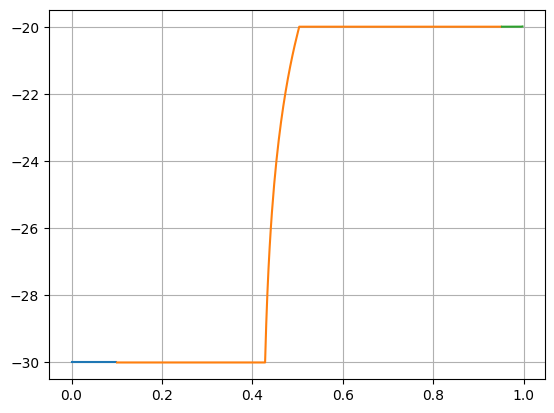

In [11]:

st_rel_gated = calc_lra_vals(meter)
assert st_rel_gated is not None
print(f'{st_rel_gated.shape=}, {st_rel_gated.min()=}, {st_rel_gated.max()=}')
lra_lo, lra_hi = calc_lra_percentiles(st_rel_gated)
print(f'{lra_lo=}, {lra_hi=}, lra={lra_hi - lra_lo}')

# lo_hi = np.percentile(st_rel_gated, [PRC_LO, PRC_HI])
# print(f'{lo_hi=}, {lo_hi[1] - lo_hi[0]=}')
# st_rel_gated_sorted = np.sort(st_rel_gated)
# # ix_arr = np.rint(np.arange(st_rel_gated_sorted.size) / 100)
# n = st_rel_gated_sorted.size
# lra_lo = st_rel_gated_sorted[round((n-1) * PRC_LO/100 + 0)]
# lra_hi = st_rel_gated_sorted[round((n-1) * PRC_HI/100 + 0)]
# print(f'{lra_lo=}, {lra_hi=}, lra={lra_hi - lra_lo}')
# pct_x = np.arange(st_rel_gated_sorted.size) / st_rel_gated_sorted.size
# ix = np.logical_and(pct_x>=PRC_LO/100, pct_x <=PRC_HI/100)
# ix_lo, ix_hi = st_rel_gated_sorted[ix][0], st_rel_gated_sorted[ix][-1]
# print(f'{ix_lo=}, {ix_hi=}, {ix_hi - ix_lo=}')

st_rel_gated_sorted = np.sort(st_rel_gated)
pct_x = np.arange(st_rel_gated_sorted.size) / st_rel_gated_sorted.size
lra_ma_lo = st_rel_gated_sorted.view(np.ma.MaskedArray)
lra_ma_mid = st_rel_gated_sorted.view(np.ma.MaskedArray)
lra_ma_hi = st_rel_gated_sorted.view(np.ma.MaskedArray)
lra_ma_lo[pct_x>.1] = np.ma.masked
# lra_ma_mid[np.logical_and(pct_x<=.1, pct_x>=.95)] = np.ma.masked
# lra_ma_mid[:] = np.ma.masked
lra_ma_mid[pct_x<=.1] = np.ma.masked
lra_ma_mid[pct_x>=.95] = np.ma.masked
lra_ma_hi[pct_x<.95] = np.ma.masked
_ = plt.plot(pct_x, lra_ma_lo, pct_x, lra_ma_mid, pct_x, lra_ma_hi)
plt.grid()

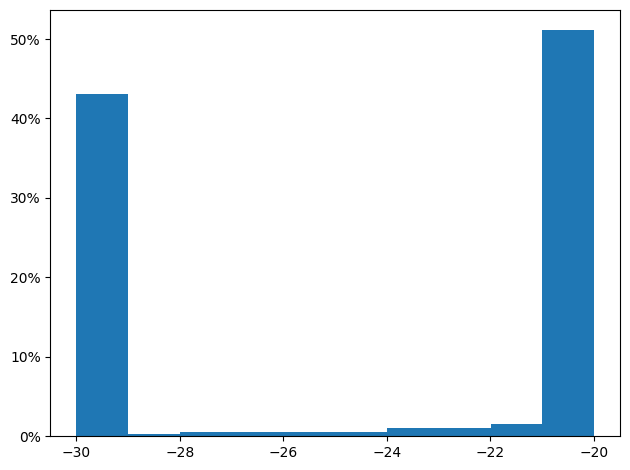

In [12]:
# assert st_rel_gated is not None
fig, ax = plt.subplots(tight_layout=True)

_ = ax.hist(
    meter.processor.short_term_lkfs,
    density=True,
    # bins=np.arange(70)-70,
    bins='auto',
)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

# hist, bins = np.histogram(st_rel_gated, bins=np.arange(100))
# plt.plot(bins, hist)
